In [82]:
!pip install tensorflow scikit-learn shap


In [83]:
!pip install keras_tuner

In [84]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model


# 'group' is the last column
data = pd.read_csv("to_clustr.csv")


In [85]:
# Split predictors (X) and target (y)
X = data.iloc[:, :-1].values
y = data['group'].values


In [86]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [87]:
# Standardize the predictors
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [88]:

def build_model(hp):
    model = Sequential()

    # First layer: tune number of units and activation function
    model.add(Dense(
        units=hp.Int('units_layer_1', min_value=32, max_value=128, step=32),
        activation=hp.Choice('activation_layer_1', values=['relu', 'tanh']),
        input_dim=X_train.shape[1]  # Input layer shape
    ))

    # Add a tunable number of additional hidden layers
    for i in range(hp.Int('num_hidden_layers', 1, 4)):  # Number of hidden layers between 1 and 10
        model.add(Dense(
            units=hp.Int(f'units_layer_{i+2}', min_value=16, max_value=128, step=16),
            activation=hp.Choice(f'activation_layer_{i+2}', values=['relu', 'tanh'])
        ))

    # Output layer (fixed)
    model.add(Dense(1, activation='sigmoid'))

    # Tune learning rate for Adam optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [89]:

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Run each configuration once
    directory='my_dir',  # Directory to save results
    project_name='hyperparameter_tuning'
)


Reloading Tuner from my_dir/hyperparameter_tuning/tuner0.json


In [90]:
# Start the search
tuner.search(X_train, y_train, epochs=100, validation_split=0.2, verbose=1, batch_size=32)


In [91]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first hidden layer is {best_hps.get('units_layer_1')}
with {best_hps.get('activation_layer_1')} activation.
The optimal number of units in the second hidden layer is {best_hps.get('units_layer_2')}
with {best_hps.get('activation_layer_2')} activation.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The optimal number of units in the first hidden layer is 64
with relu activation.
The optimal number of units in the second hidden layer is 48
with tanh activation.
The optimal learning rate for the optimizer is 0.01.



In [92]:
# Build the model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Train the final model
final_model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1, batch_size=32)

# Evaluate the model on the test set
loss, accuracy = final_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6202 - loss: 0.6760 - val_accuracy: 0.6800 - val_loss: 0.6136
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6976 - loss: 0.5953 - val_accuracy: 0.6844 - val_loss: 0.6043
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6819 - loss: 0.6003 - val_accuracy: 0.6889 - val_loss: 0.6173
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6967 - loss: 0.5895 - val_accuracy: 0.6711 - val_loss: 0.6270
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7036 - loss: 0.5784 - val_accuracy: 0.6844 - val_loss: 0.6390
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6839 - loss: 0.5962 - val_accuracy: 0.6756 - val_loss: 0.6552
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7006 - loss: 0.5884 - val_accuracy: 0.6904 - val_loss: 0.6163
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6925 - loss: 0.5843 - val_accuracy: 0.669

In [93]:
# Evaluate on test data
loss, accuracy = final_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6417 - loss: 0.7286 
Test Accuracy: 0.63


PermutationExplainer explainer: 845it [02:00,  6.29it/s]


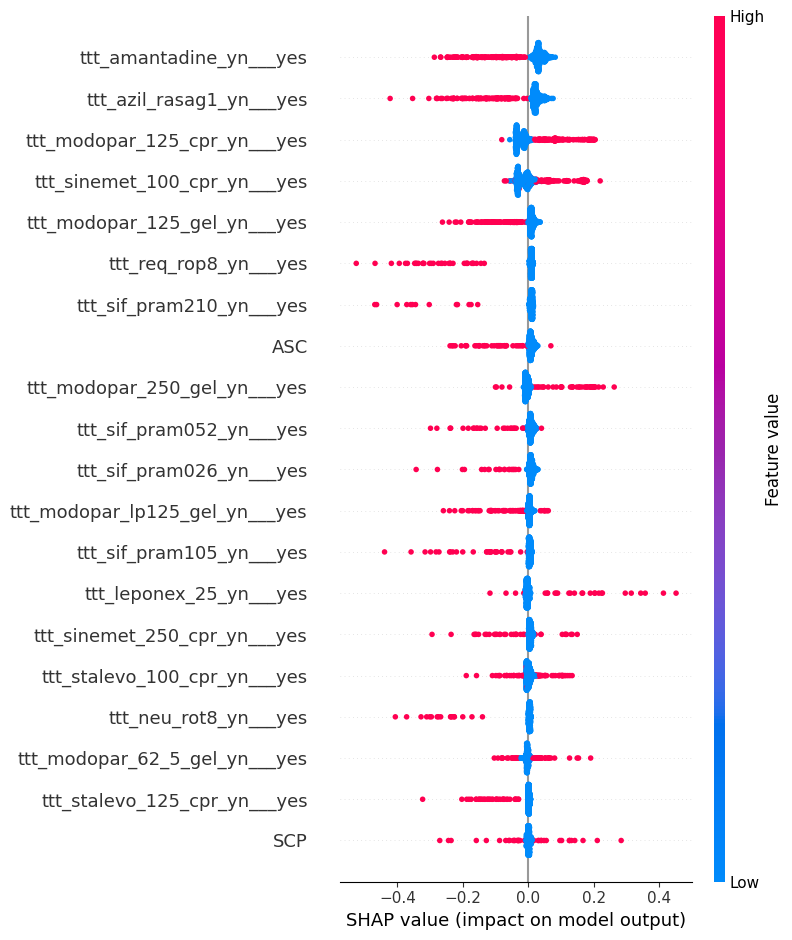

In [94]:
import shap

# Explain the predictions using SHAP
explainer = shap.Explainer(final_model, X_train)
shap_values = explainer(X_test)

# Plot the summary of feature importance
shap.summary_plot(shap_values, X_test, feature_names=data.columns[:-1])

In [95]:
help(shap.summary_plot)

Help on function summary_legacy in module shap.plots._beeswarm:

summary_legacy(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7d5177ac0550>, show_values_in_legend=False, use_log_scale=False)
    Create a SHAP beeswarm plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature

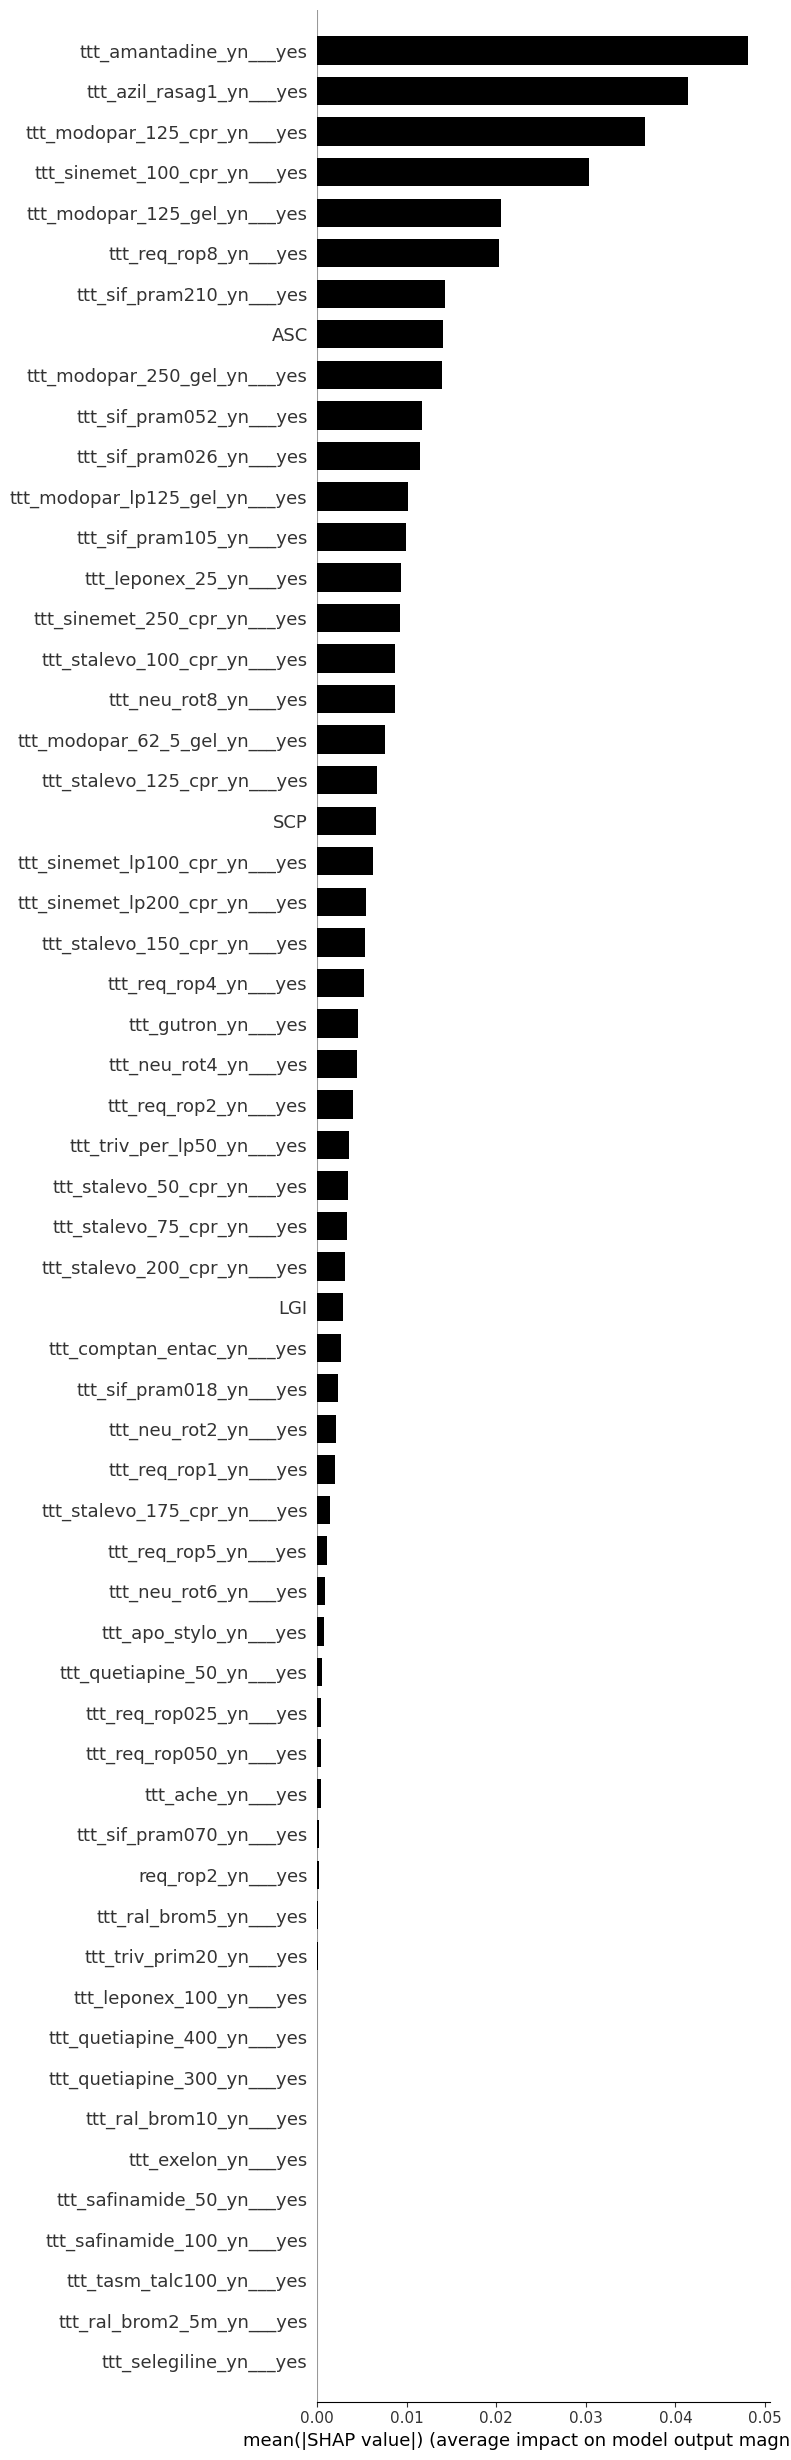

In [96]:
# Bar plot of mean absolute SHAP values
shap.summary_plot(shap_values, X_test, max_display=60, feature_names=data.columns[:-1], plot_type='bar', color="black")


In [98]:
# Calculate mean absolute SHAP values for each feature
shap_values_array = shap_values.values if hasattr(shap_values, 'values') else shap_values

mean_abs_shap_values = np.abs(shap_values_array).mean(axis=0)

# Create a DataFrame for exporting
shap_table = pd.DataFrame({
    'Feature': data.columns[:-1],  # Assuming last column is the target
    'Mean SHAP Value': mean_abs_shap_values
})

# Sort the table by SHAP values (descending order)
shap_table = shap_table.sort_values(by='Mean SHAP Value', ascending=False)

# Save to CSV for use in Excel
shap_table.to_csv('shap_values_table.csv', index=False)


In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_pred_proba = final_model.predict(X_test).ravel()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.2f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
AUC: 0.64


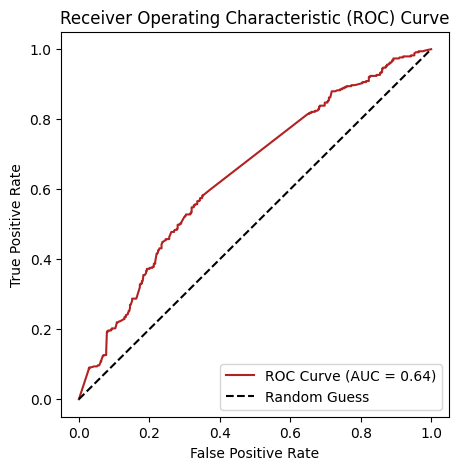

In [17]:
# Plot the ROC Curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color='firebrick')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Dashed diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


In [18]:
print("Training set class distribution:", np.bincount(y_train))
print("Test set class distribution:", np.bincount(y_test))

Training set class distribution: [2187 1185]
Test set class distribution: [503 341]


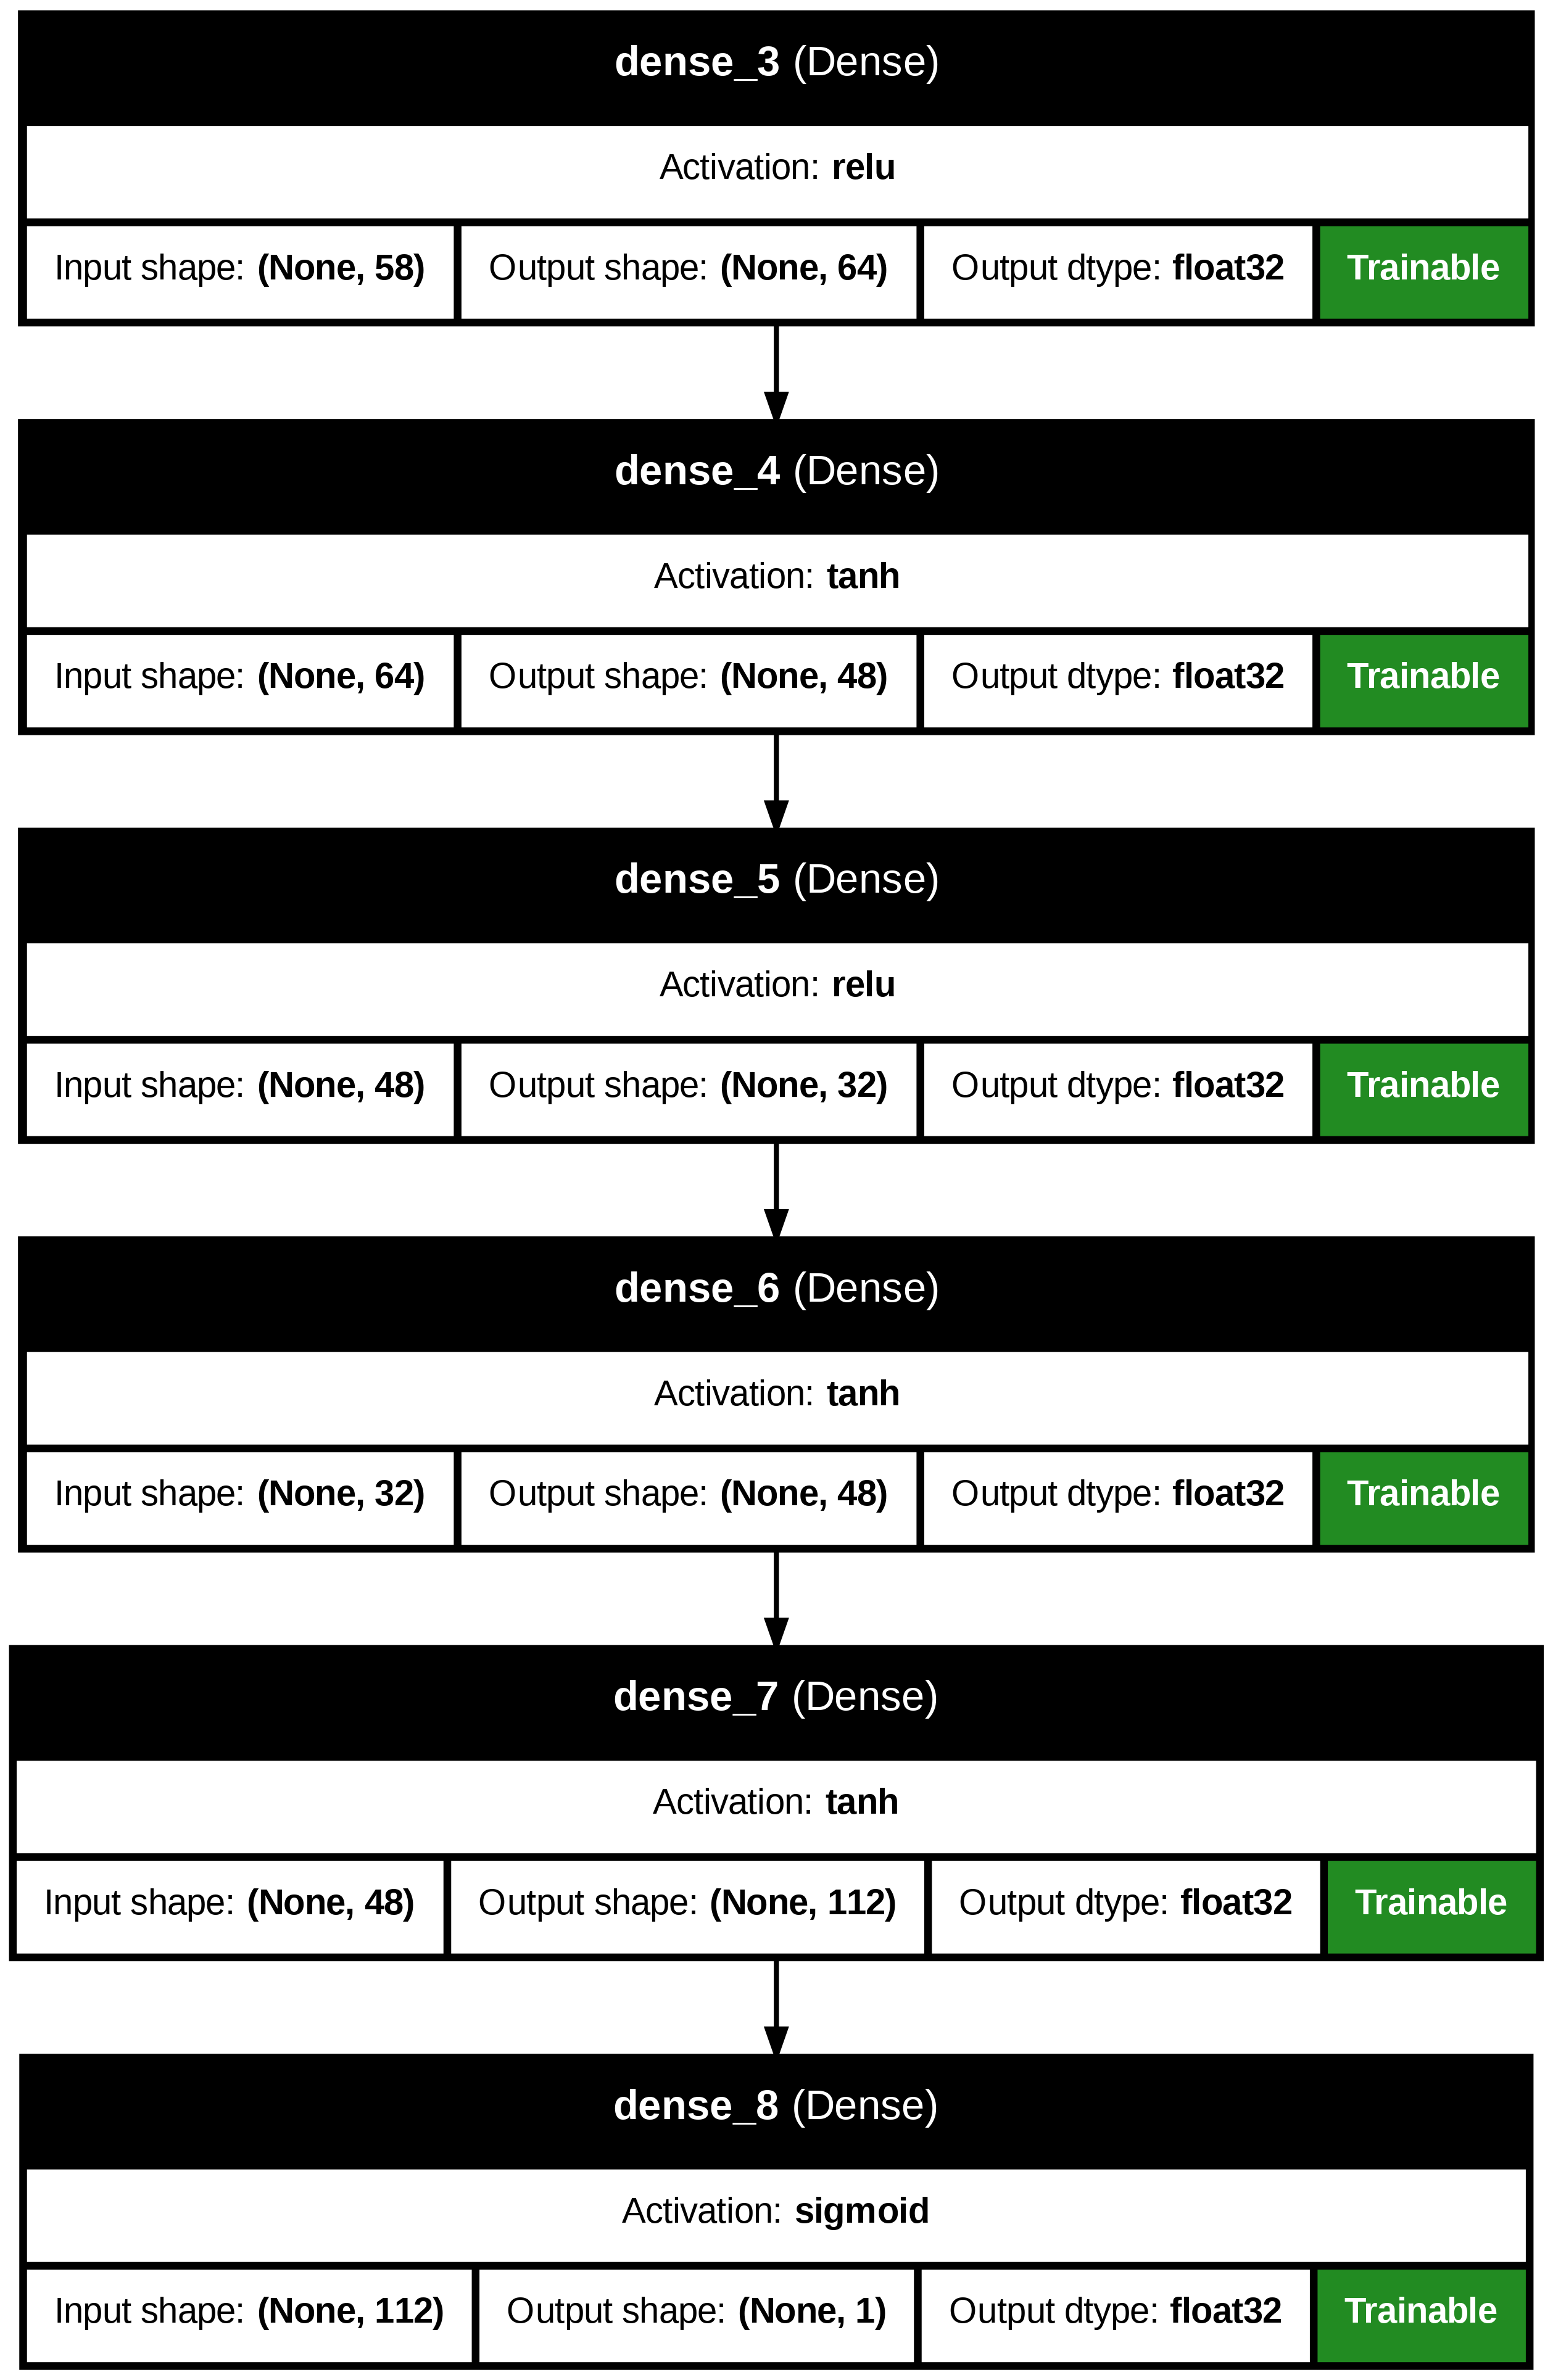

In [19]:
plot_model(final_model, to_file='model_architecture.png',
           show_shapes=True, show_layer_names=True, expand_nested=True,
            show_dtype=True, show_layer_activations=True, show_trainable=True,
           rankdir='TB', dpi=300)

In [20]:
# Group by 'group' and 'ttt_azil_rasag1_yn___yes', then calculate count

#ttt_modopar_125_cpr_yn___yes
#ttt_azil_rasag1_yn___yes
#ttt_amantadine_yn___yes
#ttt_sinemet_100_cpr_yn___yes
#ASC

grouped_counts = data.groupby(['group', 'ttt_modopar_125_cpr_yn___yes']).size().reset_index(name='count')
# Calculate the total count for each group
total_counts = data.groupby('group').size().reset_index(name='total_count')
# Merge total counts back to the grouped counts to calculate percentages
grouped_counts = pd.merge(grouped_counts, total_counts, on='group')
# Calculate percentage
grouped_counts['percentage'] = (grouped_counts['count'] / grouped_counts['total_count']) * 100
# Drop the 'total_count' column if it's no longer needed
grouped_counts = grouped_counts.drop(columns=['total_count'])
# Print the results
print(grouped_counts)

grouped_counts = data.groupby(['group', 'ttt_azil_rasag1_yn___yes']).size().reset_index(name='count')
# Calculate the total count for each group
total_counts = data.groupby('group').size().reset_index(name='total_count')
# Merge total counts back to the grouped counts to calculate percentages
grouped_counts = pd.merge(grouped_counts, total_counts, on='group')
# Calculate percentage
grouped_counts['percentage'] = (grouped_counts['count'] / grouped_counts['total_count']) * 100
# Drop the 'total_count' column if it's no longer needed
grouped_counts = grouped_counts.drop(columns=['total_count'])
# Print the results
print(grouped_counts)

grouped_counts = data.groupby(['group', 'ttt_amantadine_yn___yes']).size().reset_index(name='count')
# Calculate the total count for each group
total_counts = data.groupby('group').size().reset_index(name='total_count')
# Merge total counts back to the grouped counts to calculate percentages
grouped_counts = pd.merge(grouped_counts, total_counts, on='group')
# Calculate percentage
grouped_counts['percentage'] = (grouped_counts['count'] / grouped_counts['total_count']) * 100
# Drop the 'total_count' column if it's no longer needed
grouped_counts = grouped_counts.drop(columns=['total_count'])
# Print the results
print(grouped_counts)

grouped_counts = data.groupby(['group', 'ttt_sinemet_100_cpr_yn___yes']).size().reset_index(name='count')
# Calculate the total count for each group
total_counts = data.groupby('group').size().reset_index(name='total_count')
# Merge total counts back to the grouped counts to calculate percentages
grouped_counts = pd.merge(grouped_counts, total_counts, on='group')
# Calculate percentage
grouped_counts['percentage'] = (grouped_counts['count'] / grouped_counts['total_count']) * 100
# Drop the 'total_count' column if it's no longer needed
grouped_counts = grouped_counts.drop(columns=['total_count'])
# Print the results
print(grouped_counts)

grouped_counts = data.groupby(['group', 'ASC']).size().reset_index(name='count')
# Calculate the total count for each group
total_counts = data.groupby('group').size().reset_index(name='total_count')
# Merge total counts back to the grouped counts to calculate percentages
grouped_counts = pd.merge(grouped_counts, total_counts, on='group')
# Calculate percentage
grouped_counts['percentage'] = (grouped_counts['count'] / grouped_counts['total_count']) * 100
# Drop the 'total_count' column if it's no longer needed
grouped_counts = grouped_counts.drop(columns=['total_count'])
# Print the results
print(grouped_counts)

   group  ttt_modopar_125_cpr_yn___yes  count  percentage
0      0                             0   2191   81.449814
1      0                             1    499   18.550186
2      1                             0   1188   77.850590
3      1                             1    338   22.149410
   group  ttt_azil_rasag1_yn___yes  count  percentage
0      0                         0   2179   81.003717
1      0                         1    511   18.996283
2      1                         0   1419   92.988204
3      1                         1    107    7.011796
   group  ttt_amantadine_yn___yes  count  percentage
0      0                        0   2151   79.962825
1      0                        1    539   20.037175
2      1                        0   1341   87.876802
3      1                        1    185   12.123198
   group  ttt_sinemet_100_cpr_yn___yes  count  percentage
0      0                             0   2214   82.304833
1      0                             1    476   17.695167
2

In [21]:

grouped_counts = data.groupby(['group', 'ttt_quetiapine_300_yn___yes']).size().reset_index(name='count')
# Calculate the total count for each group
total_counts = data.groupby('group').size().reset_index(name='total_count')
# Merge total counts back to the grouped counts to calculate percentages
grouped_counts = pd.merge(grouped_counts, total_counts, on='group')
# Calculate percentage
grouped_counts['percentage'] = (grouped_counts['count'] / grouped_counts['total_count']) * 100
# Drop the 'total_count' column if it's no longer needed
grouped_counts = grouped_counts.drop(columns=['total_count'])
# Print the results
print(grouped_counts)

   group  ttt_quetiapine_300_yn___yes  count  percentage
0      0                            0   2690       100.0
1      1                            0   1526       100.0


In [22]:
# Split predictors (X) and target (y)
X = data.iloc[:, :-1].values
y = data['group'].values

In [23]:
# Fit your neural network model
model = build_model(best_hps)  # Use your Hyperparameter tuned model
model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5808 - loss: 0.6749 - val_accuracy: 0.8566 - val_loss: 0.5354
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6193 - loss: 0.6374 - val_accuracy: 0.8803 - val_loss: 0.5082
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6572 - loss: 0.6235 - val_accuracy: 0.7796 - val_loss: 0.6459
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6257 - loss: 0.6299 - val_accuracy: 0.8578 - val_loss: 0.5932
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6498 - loss: 0.6258 - val_accuracy: 0.8744 - val_loss: 0.4458
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6610 - loss: 0.6024 - val_accuracy: 0.8199 - val_loss: 0.5785
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6707 - loss: 0.6076 - val_accuracy: 0.8780 - val_loss: 0.5232
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6606 - loss: 0.6019 - val_accuracy: 0.8614 - val_

In [24]:
# Set the fraction of data to use (e.g., 1000 samples)
subset_size = 10

# Randomly sample from X and y
subset_indices = np.random.choice(X.shape[0], size=subset_size, replace=False)
X_subset = X[subset_indices]
y_subset = y[subset_indices]

In [25]:
X_background = shap.kmeans(X, 10)

# Compute SHAP values
explainer = shap.KernelExplainer(model.predict, X_background)
shap_values = explainer.shap_values(X_subset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
648/648 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [26]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00


In [27]:
from umap import UMAP


In [28]:
shap_values_2d = shap_values.squeeze(-1)

In [29]:
from sklearn.cluster import DBSCAN


In [30]:
# Dimensionality reduction using UMAP
umap = UMAP(n_components=2, n_neighbors=200, min_dist=0)
sv_2d = umap.fit_transform(shap_values_2d)

# Clustering using DBSCAN
sv_2d_labels = DBSCAN(eps=1.5, min_samples=20).fit(sv_2d).labels_

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


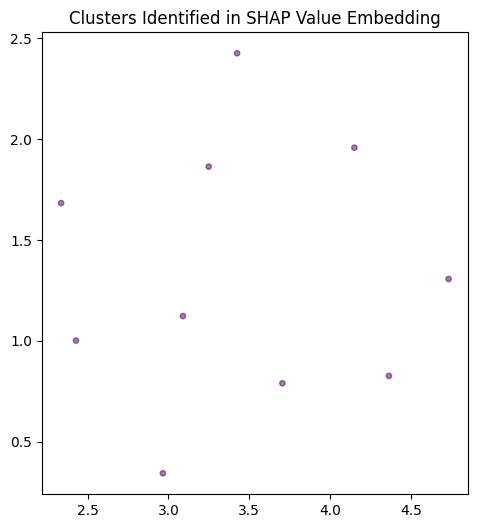

In [31]:
# Visualize the SHAP value clusters
fig, ax = plt.subplots(figsize=(5.5, 6))
ax.scatter(sv_2d[:, 0], sv_2d[:, 1], c=sv_2d_labels, s=15, alpha=0.5)
ax.set_title('Clusters Identified in SHAP Value Embedding')
fig.savefig("SHAP_clusters.png")

In [58]:
# Step 1: Randomly sample 100 rows
data_sampled = data.sample(n=50, random_state=42)

# Step 2: Split into X (features) and y (target)
X = data_sampled.iloc[:, :-1].values  # Assuming features are all columns except the last
y = data_sampled['group'].values     # Assuming 'group' is the target column


In [59]:
# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Build and train the neural network model
model = build_model(best_hps)  # Assuming `build_model` and `best_hps` are defined
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.6667 - loss: 0.6598 - val_accuracy: 0.5000 - val_loss: 0.8678
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7292 - loss: 0.5592 - val_accuracy: 0.3750 - val_loss: 0.9887
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7917 - loss: 0.4891 - val_accuracy: 0.6250 - val_loss: 1.1349
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8125 - loss: 0.3491 - val_accuracy: 0.3750 - val_loss: 2.0742
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8958 - loss: 0.2997 - val_accuracy: 0.2500 - val_loss: 2.7913
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9167 - loss: 0.2333 - val_accuracy: 0.2500 - val_loss: 2.5168
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9167 - loss: 0.2380 - val_accuracy: 0.2500 - val_loss: 2.0410
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9167 - loss: 0.2307 - val_accuracy: 0.2500 - val_loss: 2.2212

In [60]:

# Step 5: Compute SHAP values
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_train, nsamples=50)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.678e-04, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=2.508e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.631e-04, with an active set of 19 regressors, and the smallest cholesky pivot element b

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [55]:
X_test.shape

(200, 58)

In [61]:

# Convert SHAP values to 2D array
shap_values_reshaped = np.array(shap_values).reshape(len(X_train), -1)
shap_values_reshaped.shape

(40, 58)

In [62]:
from sklearn.decomposition import PCA

# Step 6: Apply PCA to SHAP values
pca = PCA(n_components=2)
shap_pca = pca.fit_transform(shap_values_reshaped)


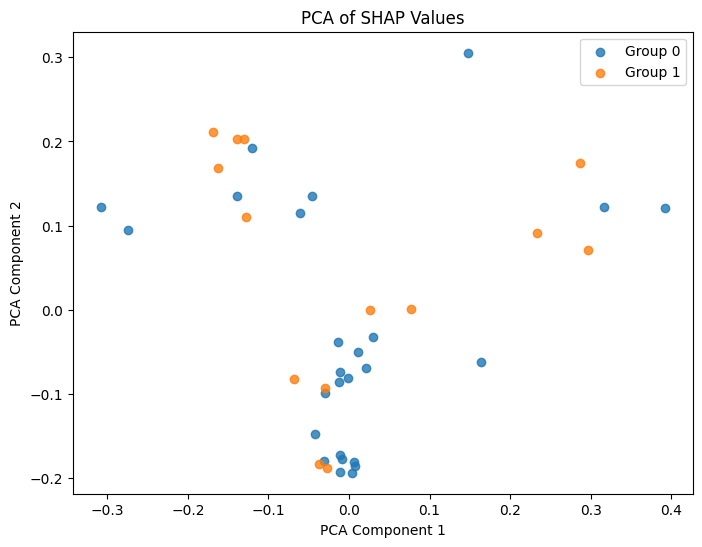

In [63]:

# Step 7: Visualize the PCA projection with color-coded labels
plt.figure(figsize=(8, 6))
for label in np.unique(y_train):
    idx = np.where(y_train == label)
    plt.scatter(shap_pca[idx, 0], shap_pca[idx, 1], label=f'Group {label}', alpha=0.8)
plt.title('PCA of SHAP Values')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()